In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

pd.set_option('display.max_columns', 200)
df = pd.read_csv("Fraud.csv")
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
# Basic cleaning & feature engineering


# 1) drop duplicates
df = df.drop_duplicates().copy()

# 2) quick missing check
print("Missing values per column:")
print(df.isna().sum())

# 3) time features from 'step' (hours)
df['hour'] = df['step'] % 24
df['day']  = df['step'] // 24

# 4) engineered balance consistency features
df['orig_diff'] = df['oldbalanceOrg'] - df['newbalanceOrig'] - df['amount']
df['dest_diff'] = df['newbalanceDest'] - df['oldbalanceDest'] - df['amount']

# 5) flags for zero balances
df['zero_old_orig'] = (df['oldbalanceOrg'] == 0).astype(int)
df['zero_new_orig'] = (df['newbalanceOrig'] == 0).astype(int)
df['zero_old_dest'] = (df['oldbalanceDest'] == 0).astype(int)
df['zero_new_dest'] = (df['newbalanceDest'] == 0).astype(int)

# 6) merchant destination flag (data dictionary: 'M...' means merchant; balances may be unknown)
df['is_merchant_dest'] = df['nameDest'].astype(str).str.startswith('M').astype(int)

# 7) one-hot encode transaction type
type_dum = pd.get_dummies(df['type'], prefix='type', drop_first=False)
df = pd.concat([df, type_dum], axis=1)

# 8) remove high-leakage identifiers
df = df.drop(columns=['nameOrig', 'nameDest'])

print("Shape after cleaning:", df.shape)
df.head()


Missing values per column:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64
Shape after cleaning: (6362620, 23)


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour,day,orig_diff,dest_diff,zero_old_orig,zero_new_orig,zero_old_dest,zero_new_dest,is_merchant_dest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0,1,0,1.455192e-11,-9839.64,0,0,1,1,1,False,False,False,True,False
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0,1,0,-1.136868e-12,-1864.28,0,0,1,1,1,False,False,False,True,False
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0,1,0,0.000000e+00,-181.00,0,1,1,1,0,False,False,False,False,True
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0,1,0,0.000000e+00,-21363.00,0,1,0,1,0,False,True,False,False,False
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0,1,0,0.000000e+00,-11668.14,0,0,1,1,1,False,False,False,True,False


In [4]:
# correlations:

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[num_cols].corr().abs()
pairs = (
    corr.where(np.triu(np.ones_like(corr), 1).astype(bool))
        .stack().sort_values(ascending=False)
)
print("Top correlated pairs:")
print(pairs.head(20))


Top correlated pairs:
step            day                 0.999539
oldbalanceOrg   newbalanceOrig      0.998803
oldbalanceDest  newbalanceDest      0.976569
amount          orig_diff           0.970660
zero_new_dest   is_merchant_dest    0.906455
zero_old_dest   zero_new_dest       0.837247
                is_merchant_dest    0.831328
zero_old_orig   zero_new_orig       0.604440
amount          newbalanceDest      0.459304
newbalanceDest  orig_diff           0.458750
newbalanceOrig  zero_new_orig       0.334857
oldbalanceOrg   zero_new_orig       0.323722
oldbalanceDest  orig_diff           0.304256
amount          oldbalanceDest      0.294137
oldbalanceDest  zero_old_dest       0.278416
newbalanceDest  zero_old_dest       0.275875
                zero_new_dest       0.262909
oldbalanceDest  zero_new_dest       0.254171
newbalanceDest  is_merchant_dest    0.238315
newbalanceOrig  zero_old_dest       0.231519
dtype: float64


In [ ]:

target = 'isFraud'
y = df[target].astype(int)
X = df.drop(columns=[target])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

num_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
preprocess = ColumnTransformer([('num', 'passthrough', num_features)], remainder='drop')

log_reg = Pipeline([
    ('prep', preprocess),
    ('scale', StandardScaler(with_mean=False)),   # sparse-safe scaler
    ('clf', LogisticRegression(max_iter=200, class_weight='balanced', solver='liblinear'))
])

rf = Pipeline([
    ('prep', preprocess),
    ('clf', RandomForestClassifier(
        n_estimators=300,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])



=== Logistic Regression ===
ROC-AUC: 0.9984
PR-AUC (AP): 0.827

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.9785    0.9891   1588602
           1     0.0562    0.9912    0.1064      2053

    accuracy                         0.9785   1590655
   macro avg     0.5281    0.9849    0.5478   1590655
weighted avg     0.9988    0.9785    0.9880   1590655

Confusion Matrix:
 [[1554450   34152]
 [     18    2035]]


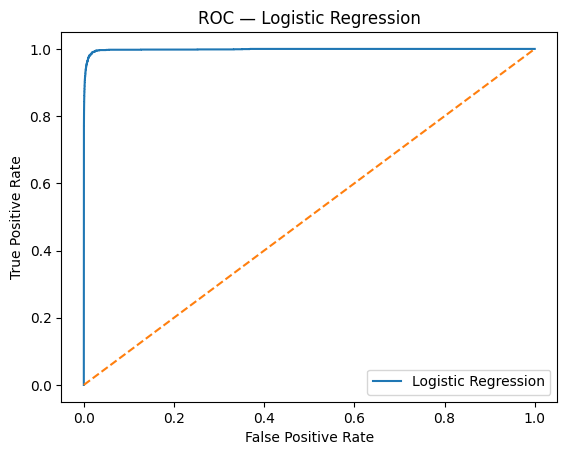

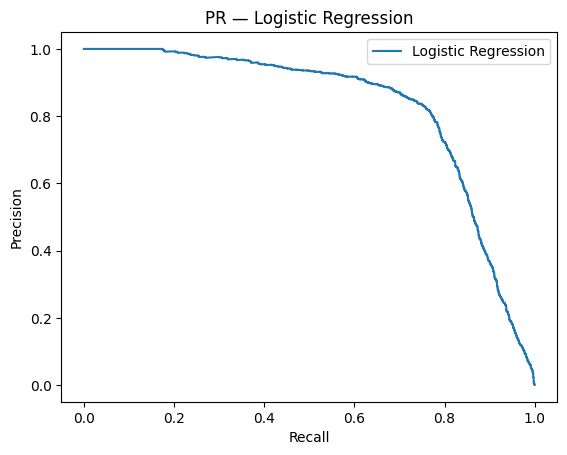


=== Random Forest ===
ROC-AUC: 0.9988
PR-AUC (AP): 0.9974

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000   1588602
           1     1.0000    0.9971    0.9985      2053

    accuracy                         1.0000   1590655
   macro avg     1.0000    0.9985    0.9993   1590655
weighted avg     1.0000    1.0000    1.0000   1590655

Confusion Matrix:
 [[1588602       0]
 [      6    2047]]


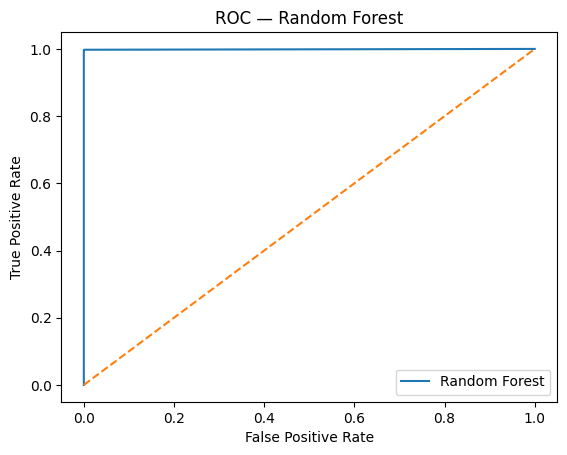

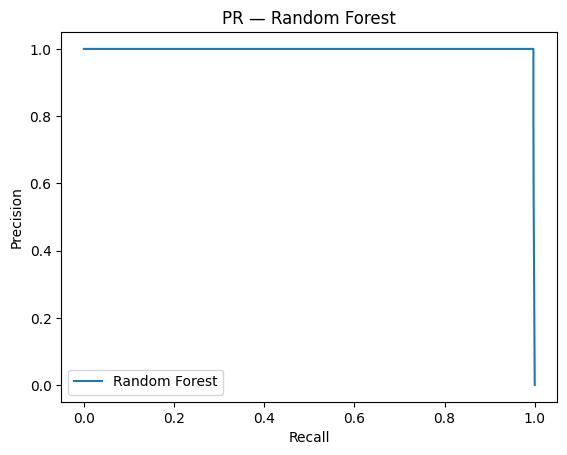

In [6]:

def evaluate(model, name):
    model.fit(X_train, y_train)
    proba = model.predict_proba(X_test)[:, 1]
    pred  = model.predict(X_test)

    roc   = roc_auc_score(y_test, proba)
    prauc = average_precision_score(y_test, proba)
    print(f"\n=== {name} ===")
    print("ROC-AUC:", round(roc, 4))
    print("PR-AUC (AP):", round(prauc, 4))
    print("\nClassification Report:\n", classification_report(y_test, pred, digits=4))
    print("Confusion Matrix:\n", confusion_matrix(y_test, pred))

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.figure()
    plt.plot(fpr, tpr, label=name)
    plt.plot([0,1],[0,1],'--')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title(f'ROC — {name}'); plt.legend(); plt.show()

    # Precision–Recall
    precision, recall, _ = precision_recall_curve(y_test, proba)
    plt.figure()
    plt.plot(recall, precision, label=name)
    plt.xlabel('Recall'); plt.ylabel('Precision')
    plt.title(f'PR — {name}'); plt.legend(); plt.show()

evaluate(log_reg, "Logistic Regression")
evaluate(rf, "Random Forest")


In [ ]:
# Logistic Regression feature importance
log_reg.fit(X_train, y_train)
feat_names = log_reg.named_steps['prep'].get_feature_names_out()
coefs = pd.Series(log_reg.named_steps['clf'].coef_.ravel(), index=feat_names)
top_abs = coefs.abs().sort_values(ascending=False)

print("Top 20 Logistic Regression features:\n", top_abs.head(20))

# Random Forest feature importance
rf.fit(X_train, y_train)
rf_imp = pd.Series(rf.named_steps['clf'].feature_importances_, index=feat_names).sort_values(ascending=False)
print("\nTop 20 Random Forest features:\n", rf_imp.head(20))


Top 20 Logistic Regression features:
 num__orig_diff           24.033746
num__is_merchant_dest     7.128492
num__amount               6.104055
num__newbalanceOrig       4.278657
num__zero_new_orig        4.265352
num__oldbalanceOrg        1.963456
num__zero_new_dest        1.722737
num__zero_old_orig        1.007455
num__isFlaggedFraud       0.616143
num__oldbalanceDest       0.549707
num__newbalanceDest       0.533931
num__hour                 0.456676
num__dest_diff            0.349461
num__zero_old_dest        0.231641
num__day                  0.157143
num__step                 0.143057
dtype: float64
